# Laboratorio: Classificazione

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Classificazione

- Nei problemi visti finora di _regressione_, l'obiettivo è prevedere il valore di una variabile _continua_
  - una quantità di energia consumata, il prezzo di una casa, ...
- Nei problemi di **_classificazione_** l'obiettivo generale è invece, per ogni osservazione, **distinguere uno di due o più casi (_classi_) possibili**
- Come per la regressione, un modello di classificazione va addestrato su esempi già correttamente classificati

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Caso di Studio 1: Predizione Default Carte di Credito

- La predizione del rischio di credito è importante per le banche per stimare in anticipo il capitale che avranno a disposizione
- Dati dei titolari di carte di credito, vogliamo predire per ogni mese se rimborseranno puntualmente le spese effettuate
- Su https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients è fornito un dataset che riassume lo stato di 30.000 titolari di carte di credito di una banca in Taiwan nel 2005
- Utilizziamo questo dataset per verificare se siamo in grado di addestrare un modello a predire l'insolvenza o meno dei titolari di carte

## Reperimento dei Dati

- I dati sono forniti in un file Excel, utilizziamo la funzione `read_excel` di pandas per importarli direttamente dato l'URL del file
  - deve essere installata la libreria `xlrd`
  - con `skiprows=1` ignoriamo la prima riga del file

In [2]:
ccd_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
ccd = pd.read_excel(ccd_url, skiprows=1)

- Vediamo il numero di righe e colonne

In [3]:
ccd.shape

(30000, 25)

- Di default pandas visualizza al massimo 20 colonne (prime 10 e ultime 10): il seguente comando aumenta tale limite
  - oltre a `max_columns` si può impostare `max_rows` allo stesso modo

In [4]:
pd.options.display.max_columns = 25

In [5]:
ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Significato delle Colonne

Riportiamo le informazioni sul dataset tratte dalla [fonte](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

- **`ID`** è un identificativo unico di ciascun cliente

I seguenti attributi sono di tipo categorico (nominale o ordinale), ma codificati come numeri:
- **`SEX`**: sesso
  - 1 = maschio, 2 = femmina
- **`EDUCATION`**: titolo di studio
  - 1 = laurea specialistica, 2 = laurea breve, 3 = scuola superiore, 4 = altro
- **`MARRIAGE`**: stato civile
  - 1 = sposato, 2 = nubile/celibe, 3 = altro
- **`default payment next month`**: stato pagamento dell'ultimo mese **(variabile da prevedere!)**
  - 0 = pagato, 1 = insoluto

Gli attributi puramente numerici (_intervallo_ o _ratio_) sono invece:
- **`LIMIT_BAL`**: ammontare del credito
- **`AGE`**: età
- **`PAY_x`**: stato del pagamento di x mesi prima
  - -1 = pagato in tempo
  - 1 = pagato un mese in ritardo
  - ...
  - 9 = pagato nove o più mesi in ritardo
- **`BILL_AMTx`**: somma da pagare x mesi prima
- **`PAY_AMTx`**: somma effettivamente pagata x mesi prima

## Preprocessamento di Base

- Per iniziare, impostiamo l'identificatore univoco `ID` come indice del dataset

In [6]:
ccd.set_index("ID", inplace=True)

- Inoltre, per maggiore comprensibilità, cambiamo i nomi di un paio di colonne
  - usiamo il metodo `rename` passando un dizionario che associ i nuovi nomi a quelli attuali

In [7]:
ccd.rename(columns={
    # nome attuale                nuovo nome
    "PAY_0":                      "PAY_1",
    "default payment next month": "DEFAULT"
}, inplace=True)

## Analisi Esplorativa

- Analizziamo la distribuzione dei valori nelle varie colonne
- Iniziamo dalla variabile `DEFAULT` che vogliamo predire
- Col metodo `value_counts` possiamo ottenere sia il conteggio che (con `normalize=True`) la percentuale di valori

In [8]:
ccd["DEFAULT"].value_counts()

0    23364
1     6636
Name: DEFAULT, dtype: int64

In [9]:
ccd["DEFAULT"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

- Nel dataset abbiamo quindi il 22\% circa di casi di insolvenza

- Possiamo visualizzare la stessa informazione in un grafico a torta
  - con l'opzione `labels` di `plot.pie` assegniamo etichette comprensibili ai settori
  - `sort_index` si applica al risultato di `value_counts` per garantire l'ordine delle etichette

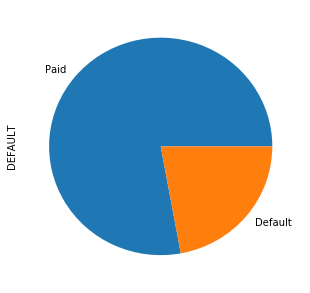

In [10]:
ccd["DEFAULT"].value_counts().sort_index() \
    .plot.pie(labels=["Paid", "Default"], figsize=(5, 5))

- Per comodità creiamo una funzione generale per grafici come questo

In [11]:
def pieplot(x, **options):
    x.value_counts().sort_index().plot.pie(**options)

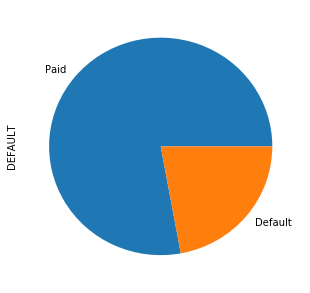

In [12]:
pieplot(ccd["DEFAULT"], labels=["Paid", "Default"], figsize=(5, 5))

- Vediamo la distribuzione per gli altri attributi categorici

In [13]:
ccd["SEX"].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [14]:
ccd["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [15]:
ccd["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

- Nelle distribuzioni vediamo valori non previsti nella descrizione del dataset
  - `EDUCATION` pari a 5, 6 o 0
  - `MARRIAGE` pari a 0
- Trattandosi di pochi casi rispetto al totale, uniamo i valori sconosciuti a quelli noti che indicano "altro"
  - 4 per `EDUCATION`, 3 per `MARRIAGE`

In [16]:
# scrivo 3 nella colonna MARRIAGE nelle righe con MARRIAGE = 0
ccd.loc[ccd["MARRIAGE"] == 0, "MARRIAGE"] = 3

In [17]:
# isin restituisce True dove il valore è uno di quelli indicati
ccd.loc[ccd["EDUCATION"].isin([5, 6, 0]), "EDUCATION"] = 4

- Le distribuzioni così aggiornate sono

In [18]:
ccd["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [19]:
ccd["MARRIAGE"].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

- Visualizziamo le distribuzioni aggiornate in grafici a torta
  - `plt.figure` inizializza una figura vuota
  - l'opzione `ax` di `plot.pie` indica in quale porzione di figura piazzare il grafico
  - `plt.subplot(R, C, N)` restituisce la N-esima porzione della figura divisa in R righe e C colonne

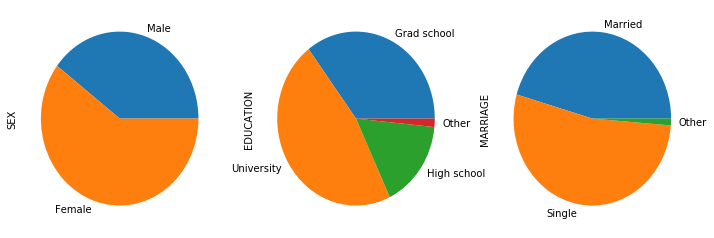

In [20]:
plt.figure(figsize=(12, 4))
pieplot(ccd["SEX"], ax=plt.subplot(1, 3, 1), labels=["Male", "Female"])
pieplot(ccd["EDUCATION"], ax=plt.subplot(1, 3, 2),
        labels=["Grad school", "University", "High school", "Other"])
pieplot(ccd["MARRIAGE"], ax=plt.subplot(1, 3, 3),
        labels=["Married", "Single", "Other"])

- Analizziamo ora le variabili numeriche
- Il metodo `describe` fornisce le statistiche principali e i quartili su tutte le variabili

In [21]:
ccd.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


- Visualizziamo ora le distribuzioni delle variabili numeriche tramite istogrammi
- Partiamo `AGE` (età) e `LIMIT_BAL` (ammontare del debito)

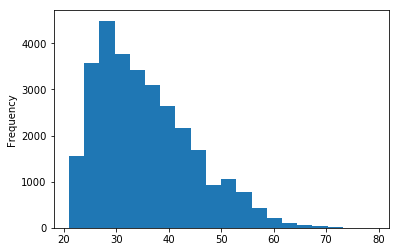

In [22]:
ccd["AGE"].plot.hist(bins=20)

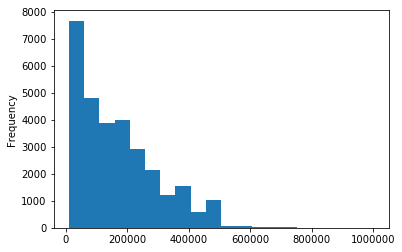

In [23]:
ccd["LIMIT_BAL"].plot.hist(bins=20)

- Visualizziamo una griglia di istogrammi per le variabili `PAY_n`, ovvero i mesi di ritardo nei precedenti pagamenti
  - essendoci pochi valori interi, invece di `hist` sulla serie usiamo `bar` su `value_counts` per visualizzare una barra per ciascuno

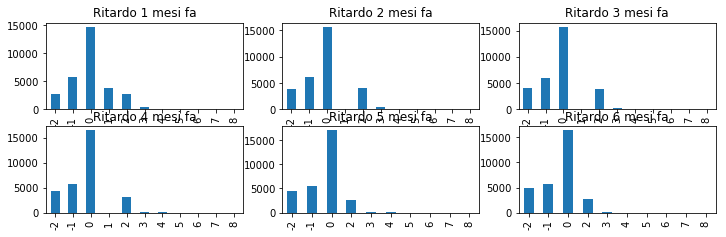

In [24]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_{}".format(n)].value_counts().sort_index().plot.bar(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

- Assumiamo che i valori -2 e -1 contino come 0, li sovrascriviamo e rigeneriamo i grafici

In [25]:
for n in range(1, 7):
    col = "PAY_{}".format(n)
    ccd.loc[ccd[col] < 0, col] = 0

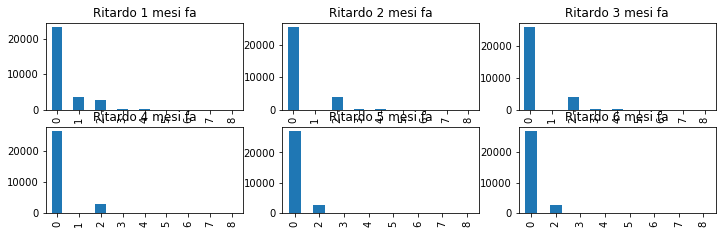

In [26]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_{}".format(n)].value_counts().sort_index().plot.bar(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

- Generiamo istogrammi in modo simile per le variabili `BILL_AMTn` e `PAY_AMTn`

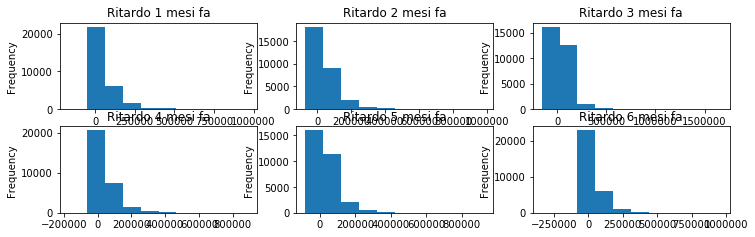

In [27]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["BILL_AMT{}".format(n)].plot.hist(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

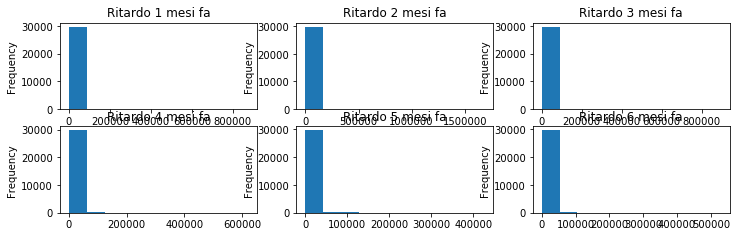

In [28]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_AMT{}".format(n)].plot.hist(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

## Divisione Training e Validation Set

- Finita l'analisi esploratoria e la correzione di alcune variabili, vediamo quali modelli possiamo addestrare per la classificazione
- Per iniziare, come al solito, usiamo la funzione `train_test_split` per suddividere casualmente il dataset in
  - un training set per l'addestramento dei modelli
  - un validation set per la loro valutazione
- Per ciascuno creiamo una serie y con la variabile `DEFAULT` da prevedere e un DataFrame X con le variabili utilizzabili per la predizione

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    ccd.drop(["DEFAULT"], axis=1),   #`X = tutto tranne DEFAULT
    ccd["DEFAULT"],                  # y = DEFAULT
    test_size=1/3, random_state=42   # opzioni
)

In [30]:
len(X_train), len(X_val)

(20000, 10000)

## Perceptron

- L'addestramento di un perceptron come di altri modelli di classificazione funziona come i modelli di regressione
- Dapprima creiamo il modello "vuoto" indicando eventuali parametri

In [31]:
from sklearn.linear_model import Perceptron
model = Perceptron()

- Usiamo quindi il metodo `fit` passando il training set, suddiviso tra le variabili predittive X e la variabile da predire y

In [32]:
model.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

## Predizioni

- Come per i modelli di regressione, usiamo il metodo `predict` per ottenere i valori di y predetti a fronte di valori di X dati
  - a differenza della regressione, tutte le predizioni saranno esattamente 0 (pagato) o 1 (insoluto)
- Estraiamo ad esempio le predizioni per il validation set

In [33]:
y_val_pred = model.predict(X_val)

- Otteniamo un array (senza etichette) con le predizioni date dal modello

In [34]:
y_val_pred[:10]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

## Accuratezza

- Come valutare quanto sono buone queste predizioni?
- Nel caso dei modelli di regressione, dove veniva predetta una variabile continua, si misura _quanto_ la predizione sia sbagliata
- Nella classificazione vanno usate altre misure
- L'_accuratezza_ di un modello di classificazione è comunemente intesa come la percentuale di esempi di un set di valutazione per cui la classe predetta dal modello coincide con quella nota

- Dato il vettore che indica in quali casi la predizione è esatta...

In [35]:
hits = y_val == y_val_pred

- ...possiamo ottenere il numero di valori `True` con `sum` e la loro percentuale con `mean`

In [36]:
hits.sum()

6716

In [37]:
hits.mean()

0.67159999999999997

- La percentuale di classificazioni corrette è quindi il 67\%, circa due terzi del dataset
- Possiamo ottenere tale percentuale rapidamente tramite il metodo `score` del modello, fornendo il set di dati per la valutazione

In [38]:
model.score(X_val, y_val)

0.67159999999999997

In [39]:
model = Perceptron(penalty="l2")
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7782

## Parametri del Modello

- Come per i modelli di regressione, possiamo vedere i parametri del modello per stimare l'importanza delle variabili
- I coefficienti per cui è moltiplicata ciascuna variabile sono dati dall'attributo `coef_`

In [40]:
model.coef_

array([[ -8.09401279e+05,   5.79528531e+02,   7.95008885e+02,
          5.76558771e+02,   1.43440862e+04,   1.28321094e+03,
          1.09071584e+03,   9.40637266e+02,   8.38510860e+02,
          7.41625416e+02,   7.06163892e+02,  -1.56635116e+05,
          4.26497842e+05,  -3.20652516e+04,   1.50667146e+05,
          2.34252573e+05,   1.57108525e+05,   5.65755006e+04,
          2.14766018e+05,  -1.35235455e+05,   1.42270141e+05,
         -1.25998965e+05,  -1.98200216e+05]])

- Avendo le variabili scale diverse, è però difficile confrontarne l'importanza

- Come visto per i modelli di regressione, utilizziamo una pipeline per standardizzare le variabili prima di fornirle al modello

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
model.fit(X_train, y_train);

In [42]:
model.score(X_val, y_val)

0.71650000000000003

- La standardizzazione ha contribuito ad aumentare l'accuratezza

- Vediamo ora i coefficienti di `Perceptron`, associandoli ai nomi delle variabili

In [43]:
pd.Series(model.named_steps["model"].coef_[0], index=X_train.columns)

LIMIT_BAL    -3.492098
SEX          -1.871292
EDUCATION    -5.918559
MARRIAGE     -1.301209
AGE           3.716737
PAY_1         4.431453
PAY_2        -1.438510
PAY_3        -6.944936
PAY_4        -1.483437
PAY_5         4.633193
PAY_6         7.575230
BILL_AMT1     3.430693
BILL_AMT2     6.543703
BILL_AMT3     1.419087
BILL_AMT4     0.648952
BILL_AMT5     5.578438
BILL_AMT6    -1.846068
PAY_AMT1     -4.596413
PAY_AMT2     12.527017
PAY_AMT3     -0.834223
PAY_AMT4      2.219242
PAY_AMT5     -6.357373
PAY_AMT6     -7.194857
dtype: float64

## Regolarizzazione

- Nel modello `Perceptron` è possibile applicare i differenti tipi di regolarizzazione visti nella regressione
  - la regolarizzazione `l2` limita i valori assoluti dei parametri del modello per evitare overfitting
  - `l1` fa sì che alcuni parametri siano nulli per scartare le variabili meno necessarie
  - `elasticnet` combina le due sopra
- Col parametro `penalty` si imposta il tipo di regolarizzazione, con `alpha` l'intensità
- Testiamo ad esempio un modello con regolarizzazione L1

In [44]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1", alpha=0.0005))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.78439999999999999

- I parametri di questo modello sono:

In [45]:
model.named_steps["model"].coef_

array([[ 0.        ,  0.        , -0.28980275,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.18182255,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

- Vediamo che sono considerate solo due variabili, che sono...

In [46]:
X_train.columns[model.named_steps["model"].coef_[0] != 0]

Index(['EDUCATION', 'PAY_6'], dtype='object')

## Regressione Logistica

- La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare
- Sia data una variabile y pari a 1 per gli esempi di una classe (positiva) e -1 per quelli dell'altra (negativa), si minimizza la funzione
$$ \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) $$
- Per addestrare tale modello, creiamo un oggetto `LogisticRegression`

In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.78180000000000005

- Testiamo un modello simile con la standardizzazione

In [49]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.81710000000000005

- Di default in `LogisticRegression` viene applicata la regolarizzazione L2, si può impostare `penalty="l1"` per applicare la L1
- Al posto del parametro `alpha` che imposta il peso della regolarizzazione, c'è un parametro `C` (_costo_) che imposta il **reciproco** di tale peso
  - maggiore è C, minore sarà la regolarizzazione

In [51]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(penalty="l1", C=10))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.81699999999999995

## Support Vector Machines

- Le _support vector machines_ sono un modello utilizzabile sia per la classificazione che la regressione
- Per la classificazione creiamo un oggetto `SVC` (support vector classification)
- Tra i parametri possiamo impostare il costo C (come per `LogisticRegression`) e il kernel da utilizzare con relativi parametri (come per `KernelRidge`)

In [50]:
%%time
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SVC(kernel="linear"))
])
model.fit(X_train, y_train)

CPU times: user 20.4 s, sys: 72.5 ms, total: 20.5 s
Wall time: 20.6 s


In [51]:
model.score(X_val, y_val)

0.82030000000000003

In [52]:
%%time
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SVC(kernel="rbf"))
])
model.fit(X_train, y_train)

CPU times: user 18.6 s, sys: 15.5 ms, total: 18.6 s
Wall time: 18.6 s


In [53]:
model.score(X_val, y_val)

0.81789999999999996

## Matrice di Confusione, Precision e Recall

- Abbiamo visto modelli che classificano correttamente fino all'82\% di esempi del validation set
- Tuttavia, considerando la distribuzione delle due classi nel validation set...

In [54]:
y_val.value_counts(normalize=True)

0    0.7818
1    0.2182
Name: DEFAULT, dtype: float64

- ...un semplice classificatore che predica sempre 0 (pagato) avrebbe un'accuratezza del 78\%
- L'accuratezza può essere quindi ingannevole in caso di classi sbilanciate
- Vediamo quindi altri modi di misurare le performance di un classificatore

- Confrontando le classi predette da un classificatore su un set di dati con quelle reali, possiamo ottenere una **_matrice di confusione_**
- Ogni cella in riga i e colonna j indica quanti esempi della classe i-esima sono stati etichettati dal classificatore come di classe j-esima
  - lungo la diagonale (i=j) abbiamo quindi le classificazioni corrette, al di fuori abbiamo gli errori
- Otteniamo la matrice col metodo `confusion_matrix`, passando i vettori di classi reali e predette

In [55]:
from sklearn.metrics import confusion_matrix
y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)

In [56]:
cm

array([[7410,  408],
       [1413,  769]])

- Per maggiore comprensione inseriamo i valori in un DataFrame, etichettando righe e colonne

In [57]:
classes = ["Paid", "Default"]
pd.DataFrame(cm, index=classes, columns=classes)

,Paid,Default
Paid,7410,408
Default,1413,769


- Ad esempio, di 2182 clienti insolventi presenti nel validation set
  - 769 sono stati etichettati come tali (_veri positivi_)
  - 1413 sono stati erroneamente etichettati come non insolventi (_falsi negativi_)
- L'accuratezza si può ottenere dalla matrice di confusione come somma dei valori nella diagonale divisa per la somma complessiva

In [58]:
cm.diagonal().sum() / cm.sum()

0.81789999999999996

- Dalla sola matrice di confusione possiamo ricavare altre misure di performance importanti
- Presa una classe X di riferimento, la **_precision_** relativa a quella classe indica la percentuale di esempi classificati come X che sono realmente tali

In [59]:
default_prc = cm[1, 1] / cm[:, 1].sum()
default_prc

0.65335598980458798

- Di contro, la **_recall_** indica la percentuale di esempi realmente di classe X che sono stati rilevati essere tali dal modello

In [60]:
default_rec = cm[1, 1] / cm[1, :].sum()
default_rec

0.35242896425297893

- Precision e recall sono quindi due indicatori complementari della bontà di un modello
- Generalmente, tarando il modello per migliorarne uno, l'altro peggiora
- Come misura unica della performance di un modello è spesso usata quindi la **_F1-measure_**, ovvero la media armonica tra precision e recall
$$ F_1 = \frac{2\cdot P\cdot R}{P+R} $$

In [61]:
2 * default_prc * default_rec / (default_prc + default_rec)

0.45787436737124143

- Per calcolare direttamente tali misure, scikit-learn fornisce le funzioni `precision_score`, `recall_score` e `f1_score`
  - col parametro `pos_label` si indica la classe di riferimento, di default 1
  - si può in alternativa ottenere un vettore di punteggi per tutte le classi (`average=None`) o la loro media (`average="macro"`)

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [63]:
precision_score(y_val, y_val_pred, pos_label=1)

0.65335598980458798

In [64]:
recall_score(y_val, y_val_pred)   # pos_label=1 sottinteso

0.35242896425297893

In [70]:
f1_score(y_val, y_val_pred, average=None)

array([ 0.89057148,  0.45787437])

In [71]:
f1_score(y_val, y_val_pred, average="macro")

0.6742229237252817

## Ottimizzazione degli Iperparametri

- Come già visto, i modelli hanno diversi iperparametri impostabili che possono influenzarne l'accuratezza
- Utilizziamo la _grid search_ per testare diverse combinazioni di iperparametri e trovare quella che fornisce risultati migliori
- Impostiamo un modello generale, definendone struttura ed eventuali iperparametri fissi

In [117]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("perc",   Perceptron())
])

- Definiamo quindi una _griglia_ di parametri da variare, in questo caso il tipo e il peso della regolarizzazione
  - `X__Y` indica il parametro `Y` del componente `X` della pipeline

In [116]:
grid = {
    "perc__penalty": [None, "l1", "l2", "elasticnet"],
    "perc__alpha": np.logspace(-3, 3, 7)   # [0.001, 0.01, ..., 100, 1000]
}

- Creiamo quindi un modello `GridSearchCV` con i due oggetti definiti sopra...

In [120]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid)

- ...ed addestriamolo sul training set

In [121]:
gs.fit(X_train, y_train);

- Viene eseguita una cross validation su tutte le combinazioni di iperparametri e per quella con migliore accuratezza (`score`) viene addestrato un modello su tutti i dati
- Possiamo testare tale modello sul validation set

In [122]:
gs.score(X_val, y_val)

0.78180000000000005

- Possiamo inoltre consultare i risultati dettagliati sulle diverse combinazioni di iperparametri
  - ordinando per `rank_test_score` otteniamo in testa i risultati migliori

In [125]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_perc__alpha,param_perc__penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,0.029577,0.001997,0.7773,0.7773,1,l1,"{'perc__alpha': 1.0, 'perc__penalty': 'l1'}",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000152,0.000008,0.000055,0.000027
25,0.029696,0.002536,0.7773,0.7773,1000,l1,"{'perc__alpha': 1000.0, 'perc__penalty': 'l1'}",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000182,0.000756,0.000055,0.000027
23,0.031210,0.001998,0.7773,0.7773,100,elasticnet,"{'perc__alpha': 100.0, 'perc__penalty': 'elast...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000127,0.000001,0.000055,0.000027
22,0.025584,0.001994,0.7773,0.7773,100,l2,"{'perc__alpha': 100.0, 'perc__penalty': 'l2'}",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000067,0.000006,0.000055,0.000027
21,0.029676,0.001997,0.7773,0.7773,100,l1,"{'perc__alpha': 100.0, 'perc__penalty': 'l1'}",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000189,0.000007,0.000055,0.000027


- Nel modello generale abbiamo imposto la standardizzazione ai dati, ma può non essere necessaria
- Possiamo impostare la griglia in modo da rendere opzionale un componente della pipeline

In [128]:
grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": ["l1", "l2", "elasticnet"],
    "perc__alpha": np.logspace(0, 3, 4)
}

- In questo modo, la grid search testerà il modello con (`StandardScaler()`) e senza (`None`) standardizzazione

In [129]:
gs = GridSearchCV(model, grid)
gs.fit(X_train, y_train);

In [130]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_perc__alpha,param_perc__penalty,param_scaler,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,0.030879,0.002004,0.7773,0.7773,10,elasticnet,"StandardScaler(copy=True, with_mean=True, with...","{'perc__alpha': 10.0, 'perc__penalty': 'elasti...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000357,0.000007,0.000055,0.000027
21,0.026396,0.002087,0.7773,0.7773,1000,l2,"StandardScaler(copy=True, with_mean=True, with...","{'perc__alpha': 1000.0, 'perc__penalty': 'l2',...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000137,0.000015,0.000055,0.000027
20,0.023792,0.002709,0.7773,0.7773,1000,l2,None,"{'perc__alpha': 1000.0, 'perc__penalty': 'l2',...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000419,0.001767,0.000055,0.000027
19,0.030564,0.002068,0.7773,0.7773,1000,l1,"StandardScaler(copy=True, with_mean=True, with...","{'perc__alpha': 1000.0, 'perc__penalty': 'l1',...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000534,0.000011,0.000055,0.000027
18,0.025825,0.004821,0.7773,0.7773,1000,l1,None,"{'perc__alpha': 1000.0, 'perc__penalty': 'l1',...",1,0.777261,0.777319,0.777261,0.777319,0.777378,0.777261,0.000336,0.004186,0.000055,0.000027


- Testiamo in modo simile la regressione logistica

In [132]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression())
])
grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-3, 3, 7)
}
gs = GridSearchCV(model, grid)
gs.fit(X_train, y_train);

In [133]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_lr__C,param_lr__penalty,param_scaler,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,0.087015,0.002131,0.81830,0.818650,0.1,l2,"StandardScaler(copy=True, with_mean=True, with...","{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",1,0.820009,0.816470,0.817159,0.819320,0.817732,0.820159,0.005669,0.000023,0.001231,0.001579
22,0.182098,0.001286,0.81825,0.818850,100,l1,None,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...",2,0.820159,0.816620,0.817159,0.819695,0.817432,0.820234,0.015687,0.000005,0.001354,0.001592
26,0.204000,0.001537,0.81820,0.818900,1000,l1,None,"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",3,0.820159,0.816545,0.817009,0.819845,0.817432,0.820309,0.012961,0.000213,0.001396,0.001676
13,0.081147,0.002139,0.81815,0.818800,1,l2,"StandardScaler(copy=True, with_mean=True, with...","{'lr__C': 1.0, 'lr__penalty': 'l2', 'scaler': ...",4,0.820159,0.816470,0.817009,0.819695,0.817282,0.820234,0.007297,0.000010,0.001425,0.001662
25,0.086625,0.002067,0.81815,0.818825,1000,l2,"StandardScaler(copy=True, with_mean=True, with...","{'lr__C': 1000.0, 'lr__penalty': 'l2', 'scaler...",4,0.820159,0.816395,0.817009,0.819845,0.817282,0.820234,0.007447,0.000055,0.001425,0.001725


- Di default i modellli sono ritenuti migliori di altri in base all'accuratezza, cioè la percentuale di classificazioni corrette
- Col parametro `scoring` di `GridSearchCV` possiamo però definire una diversa metrica di paragone
- Basiamoci ad esempio sulla F1-measure, impostando `scoring="f1"`

In [137]:
gs = GridSearchCV(model, grid, scoring="f1")
gs.fit(X_train, y_train);

/home/pasolini/software/miniconda3/envs/dialab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pasolini/software/miniconda3/envs/dialab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pasolini/software/miniconda3/envs/dialab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pasolini/software/miniconda3/envs/dialab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precisio

- Questa volta la colonna `mean_test_score` (e tutte le altre `*_score`) riportano la F1 al posto dell'accuratezza e il ranking dei modelli è basato su di essa

In [138]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_lr__C,param_lr__penalty,param_scaler,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,0.090012,0.003705,0.453709,0.454013,0.1,l2,"StandardScaler(copy=True, with_mean=True, with...","{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",1,0.447514,0.441707,0.442105,0.455839,0.471509,0.464493,0.006358,0.000874,0.012778,0.009392
26,0.189221,0.002267,0.453249,0.454559,1000,l1,None,"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",2,0.447926,0.441653,0.442105,0.456846,0.469717,0.465179,0.016470,0.000029,0.011884,0.009739
22,0.216717,0.004441,0.452856,0.454372,100,l1,None,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...",3,0.447211,0.441197,0.442105,0.456846,0.469254,0.465075,0.023065,0.002745,0.011780,0.009904
18,0.207677,0.002409,0.452856,0.454407,10,l1,None,"{'lr__C': 10.0, 'lr__penalty': 'l1', 'scaler':...",3,0.447211,0.441197,0.442105,0.456949,0.469254,0.465075,0.016832,0.000110,0.011780,0.009913
14,0.176353,0.002449,0.452840,0.454638,1,l1,None,"{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...",5,0.446494,0.441096,0.442105,0.457298,0.469922,0.465521,0.022325,0.000021,0.012210,0.010147
